# SEIS 631 - Final Project - Group 4
Yue Cade \
Tony Challeen \
Siphosenkosi Mpofu \
Jason Shapiro \
Brian Susick

In [244]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

Q1) Show me the market trends to help me decide. Which US real-estate market is doing best overall. -Jason

* Assumptions:
    * For general market trends, we're going to use smoothed/seasonal data to look at overall trends over a period of a year.
    * The housing market was affected by the pandemic causing unusual home selling/buying patterns, so we're going to focus on state from 2023 onwwards.
    * Although we will look at current state later in this work, we'll begin with looking at home value forecasts to get a general sense of which regional markets we want to focus in on.
    * Rationale for focusing on forecasts for this question:
        * The underlying question here is "which market should I focus on for future profits"
        * Zillow's ZHVF methodology includes their own data with other "macroeconomic factors" (mortgage rates, economic health, etc.) that wouldn't be taken in by just creating a regression from historical housing prices
    

In [245]:
# Load the data

# Zillow Home Value Forecast (ZHVF): 
# Each numerical value represents the projected percentage change. 
# Example: 0.2 = 0.2% increase; -0.2 = 0.2% decrease in home values

df = pd.read_csv("data/Metro_zhvf_growth_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

display(df.head(5))  
display(df.tail(5))
display(df.count())

,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
0,102001,0,United States,country,NaN,2024-10-31,0.2,0.6,2.9
1,394913,1,"New York, NY",msa,NY,2024-10-31,0.3,0.5,1.5
2,753899,2,"Los Angeles, CA",msa,CA,2024-10-31,0.2,0.4,2.3
3,394463,3,"Chicago, IL",msa,IL,2024-10-31,0.1,0.2,1.1
4,394514,4,"Dallas, TX",msa,TX,2024-10-31,-0.2,-0.7,1.2


,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
890,753929,935,"Zapata, TX",msa,TX,2024-10-31,-0.8,-2.6,-7.2
891,394743,936,"Ketchikan, AK",msa,AK,2024-10-31,0.2,0.1,-0.9
892,753874,937,"Craig, CO",msa,CO,2024-10-31,0.4,1.0,4.4
893,395188,938,"Vernon, TX",msa,TX,2024-10-31,-1.4,-2.2,-4.3
894,394767,939,"Lamesa, TX",msa,TX,2024-10-31,-0.2,-0.7,-4.5


RegionID      895
SizeRank      895
RegionName    895
RegionType    895
StateName     894
BaseDate      895
2024-11-30    895
2025-01-31    895
2025-10-31    895
dtype: int64

In [246]:
# List number of rows
print("Before: number of rows: ", df.shape)
 
# Drop the duplicates - (no duplicates found)
df = df.drop_duplicates()
print("After: number of rows: ", df.shape)
 
# Drop Missing/Null Values (no null values found)
print("Sum of null values: ", df.isnull().sum())

# Drop rows with NaN values
display(df.count())
df = df.dropna() 
display(df.count())

display(df.head(5))
display(df.tail(5))

# This data is exceptionally clean - we only needed to drop the 1st row which isn't at the state level

Before: number of rows:  (895, 9)
After: number of rows:  (895, 9)
Sum of null values:  RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     1
BaseDate      0
2024-11-30    0
2025-01-31    0
2025-10-31    0
dtype: int64


RegionID      895
SizeRank      895
RegionName    895
RegionType    895
StateName     894
BaseDate      895
2024-11-30    895
2025-01-31    895
2025-10-31    895
dtype: int64

RegionID      894
SizeRank      894
RegionName    894
RegionType    894
StateName     894
BaseDate      894
2024-11-30    894
2025-01-31    894
2025-10-31    894
dtype: int64

,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
1,394913,1,"New York, NY",msa,NY,2024-10-31,0.3,0.5,1.5
2,753899,2,"Los Angeles, CA",msa,CA,2024-10-31,0.2,0.4,2.3
3,394463,3,"Chicago, IL",msa,IL,2024-10-31,0.1,0.2,1.1
4,394514,4,"Dallas, TX",msa,TX,2024-10-31,-0.2,-0.7,1.2
5,394692,5,"Houston, TX",msa,TX,2024-10-31,-0.2,-0.6,0.6


,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2024-11-30,2025-01-31,2025-10-31
890,753929,935,"Zapata, TX",msa,TX,2024-10-31,-0.8,-2.6,-7.2
891,394743,936,"Ketchikan, AK",msa,AK,2024-10-31,0.2,0.1,-0.9
892,753874,937,"Craig, CO",msa,CO,2024-10-31,0.4,1.0,4.4
893,395188,938,"Vernon, TX",msa,TX,2024-10-31,-1.4,-2.2,-4.3
894,394767,939,"Lamesa, TX",msa,TX,2024-10-31,-0.2,-0.7,-4.5


In [247]:
# Rename column headers to snake_case and more appropriate terms
df = df.rename(columns={"RegionID": "region_id", 
                        "SizeRank": "size_rank", 
                        "RegionName": "metro_area",
                        "RegionType": "region_type",
                        "StateName": "state_name",
                        "BaseDate": "base_date", 
                        "2024-11-30": "month_ahead_forecast", 
                        "2025-01-31": "quarter_ahead_forecast", 
                        "2025-10-31": "year_ahead_forecast"})
df.head(5)

# View a couple of columns to confirm the suspicion that the data is redundant/repeated or simply not needed
display(df['region_type'].unique())
display(df['base_date'].unique())

# Drop unnecessary columns
df = df.drop(["region_id", "size_rank", "region_type", "base_date"], axis=1)
display(df.head(5))

array(['msa'], dtype=object)

array(['2024-10-31'], dtype=object)

,metro_area,state_name,month_ahead_forecast,quarter_ahead_forecast,year_ahead_forecast
1,"New York, NY",NY,0.3,0.5,1.5
2,"Los Angeles, CA",CA,0.2,0.4,2.3
3,"Chicago, IL",IL,0.1,0.2,1.1
4,"Dallas, TX",TX,-0.2,-0.7,1.2
5,"Houston, TX",TX,-0.2,-0.6,0.6


In [248]:
# Add a "Region" column

# Define the regions
northeast = ["CT", "ME", "MA", "NH", "RI", "VT", "NJ", "NY", "PA"]
midwest = ["IL", "IN", "IA", "KS", "MI", "MN", "MO", "NE", "ND", "OH", "SD", "WI"]
south = ["AL", "AR", "DE", "FL", "GA", "KY", "LA", "MD", "MS", "NC", "OK", "SC", "TN", "TX", "VA", "WV"]
west = ["AK", "AZ", "CA", "CO", "HI", "ID", "MT", "NV", "NM", "OR", "UT", "WA", "WY"]

# Map states to regions
region_map = {}
region_map.update({state: "northeast" for state in northeast})
region_map.update({state: "midwest" for state in midwest})
region_map.update({state: "south" for state in south})
region_map.update({state: "west" for state in west})

display(region_map)

# Add the Region column
df.insert(2, "region", df["state_name"].map(region_map))

df.head(5)


{'CT': 'northeast',
 'ME': 'northeast',
 'MA': 'northeast',
 'NH': 'northeast',
 'RI': 'northeast',
 'VT': 'northeast',
 'NJ': 'northeast',
 'NY': 'northeast',
 'PA': 'northeast',
 'IL': 'midwest',
 'IN': 'midwest',
 'IA': 'midwest',
 'KS': 'midwest',
 'MI': 'midwest',
 'MN': 'midwest',
 'MO': 'midwest',
 'NE': 'midwest',
 'ND': 'midwest',
 'OH': 'midwest',
 'SD': 'midwest',
 'WI': 'midwest',
 'AL': 'south',
 'AR': 'south',
 'DE': 'south',
 'FL': 'south',
 'GA': 'south',
 'KY': 'south',
 'LA': 'south',
 'MD': 'south',
 'MS': 'south',
 'NC': 'south',
 'OK': 'south',
 'SC': 'south',
 'TN': 'south',
 'TX': 'south',
 'VA': 'south',
 'WV': 'south',
 'AK': 'west',
 'AZ': 'west',
 'CA': 'west',
 'CO': 'west',
 'HI': 'west',
 'ID': 'west',
 'MT': 'west',
 'NV': 'west',
 'NM': 'west',
 'OR': 'west',
 'UT': 'west',
 'WA': 'west',
 'WY': 'west'}

,metro_area,state_name,region,month_ahead_forecast,quarter_ahead_forecast,year_ahead_forecast
1,"New York, NY",NY,northeast,0.3,0.5,1.5
2,"Los Angeles, CA",CA,west,0.2,0.4,2.3
3,"Chicago, IL",IL,midwest,0.1,0.2,1.1
4,"Dallas, TX",TX,south,-0.2,-0.7,1.2
5,"Houston, TX",TX,south,-0.2,-0.6,0.6


In [249]:
# Calculate overall forecast
df['overall_forecast'] = df[['month_ahead_forecast', 'quarter_ahead_forecast', 'year_ahead_forecast']].mean(axis=1)

# Group by region and calculate mean forecasts
grouped_df = df.groupby('region').mean(numeric_only=True)
display(grouped_df)

,month_ahead_forecast,quarter_ahead_forecast,year_ahead_forecast,overall_forecast
region,,,,
midwest,0.242857,0.522344,2.251648,1.005617
northeast,0.182022,0.431461,2.943820,1.185768
south,-0.123184,-0.188547,1.452793,0.380354
west,0.069540,-0.016092,1.897701,0.650383


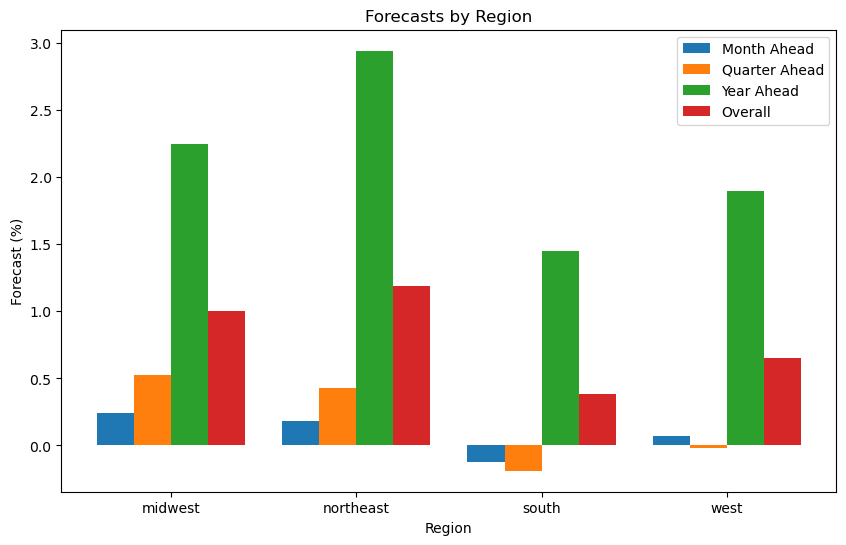

In [250]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.2
index = np.arange(len(grouped_df))


# Plot each forecast type
ax.bar(index, grouped_df['month_ahead_forecast'], bar_width, label='Month Ahead')
ax.bar(index + bar_width, grouped_df['quarter_ahead_forecast'], bar_width, label='Quarter Ahead')
ax.bar(index + bar_width * 2, grouped_df['year_ahead_forecast'], bar_width, label='Year Ahead')
ax.bar(index + bar_width * 3, grouped_df['overall_forecast'], bar_width, label='Overall')

# Set labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Forecast (%)')
ax.set_title('Forecasts by Region')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(grouped_df.index)
ax.legend()

# Show plot
plt.show()

## Bar Chart Conclusions
* Northeast has the most positive outlook for a year ahead and overall price increase
* Midwest has the most positive outlook for a month and quarter ahead

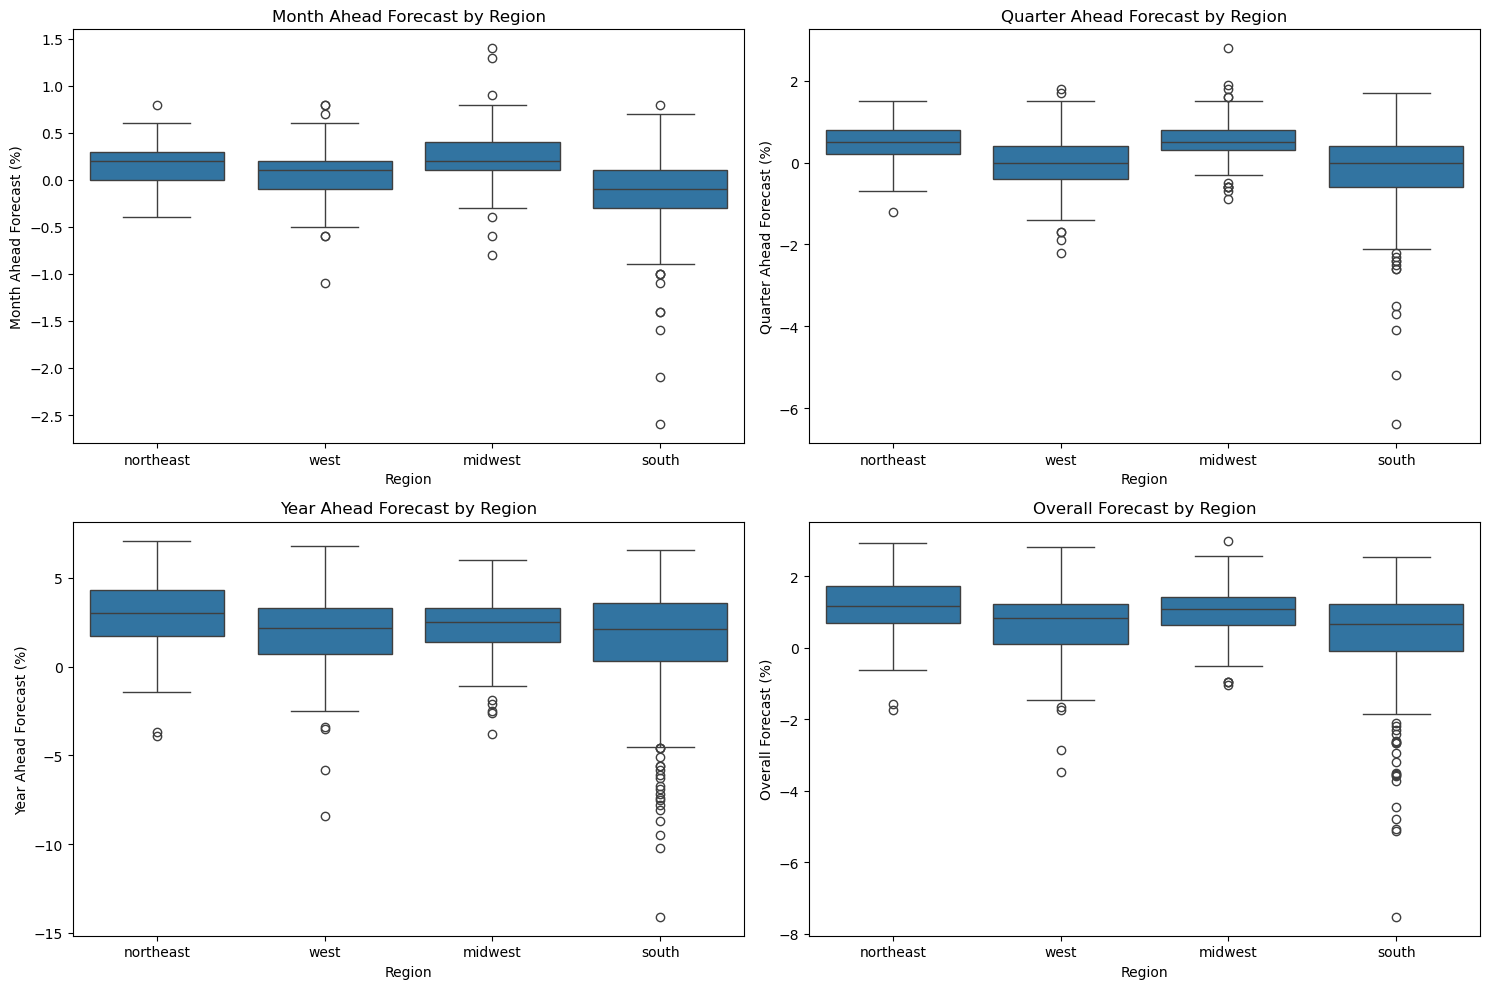

In [251]:
# Create box plots for each forecast type by region
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(x='region', y='month_ahead_forecast', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Month Ahead Forecast by Region')
axes[0, 0].set_xlabel('Region')
axes[0, 0].set_ylabel('Month Ahead Forecast (%)')

sns.boxplot(x='region', y='quarter_ahead_forecast', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Quarter Ahead Forecast by Region')
axes[0, 1].set_xlabel('Region')
axes[0, 1].set_ylabel('Quarter Ahead Forecast (%)')

sns.boxplot(x='region', y='year_ahead_forecast', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Year Ahead Forecast by Region')
axes[1, 0].set_xlabel('Region')
axes[1, 0].set_ylabel('Year Ahead Forecast (%)')

sns.boxplot(x='region', y='overall_forecast', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Overall Forecast by Region')
axes[1, 1].set_xlabel('Region')
axes[1, 1].set_ylabel('Overall Forecast (%)')

plt.tight_layout()
plt.show()

## Box Plot Conclusions
* Month Ahead
    * Variance is pretty similar across the board
    * Northeast and Midwest have the highest increases, with Northeast having a high median (stable price growth)
* Quarter Ahead
    * Similar results to Month Ahead IQR
* Year Ahead
    * Northeast has the highest growth and a high median
    * South has a great number of outliers
* Overall
    * Northeast has the highest growth and a moderate median

In [252]:
# Get the "northeast" region
northeast_df = df[df['region'] == 'northeast']

# A few examples of the data
display(northeast_df[northeast_df['state_name'] == 'VT']['month_ahead_forecast'].mean())
display(northeast_df[northeast_df['state_name'] == 'NJ']['month_ahead_forecast'].mean())

-0.22500000000000003

0.375

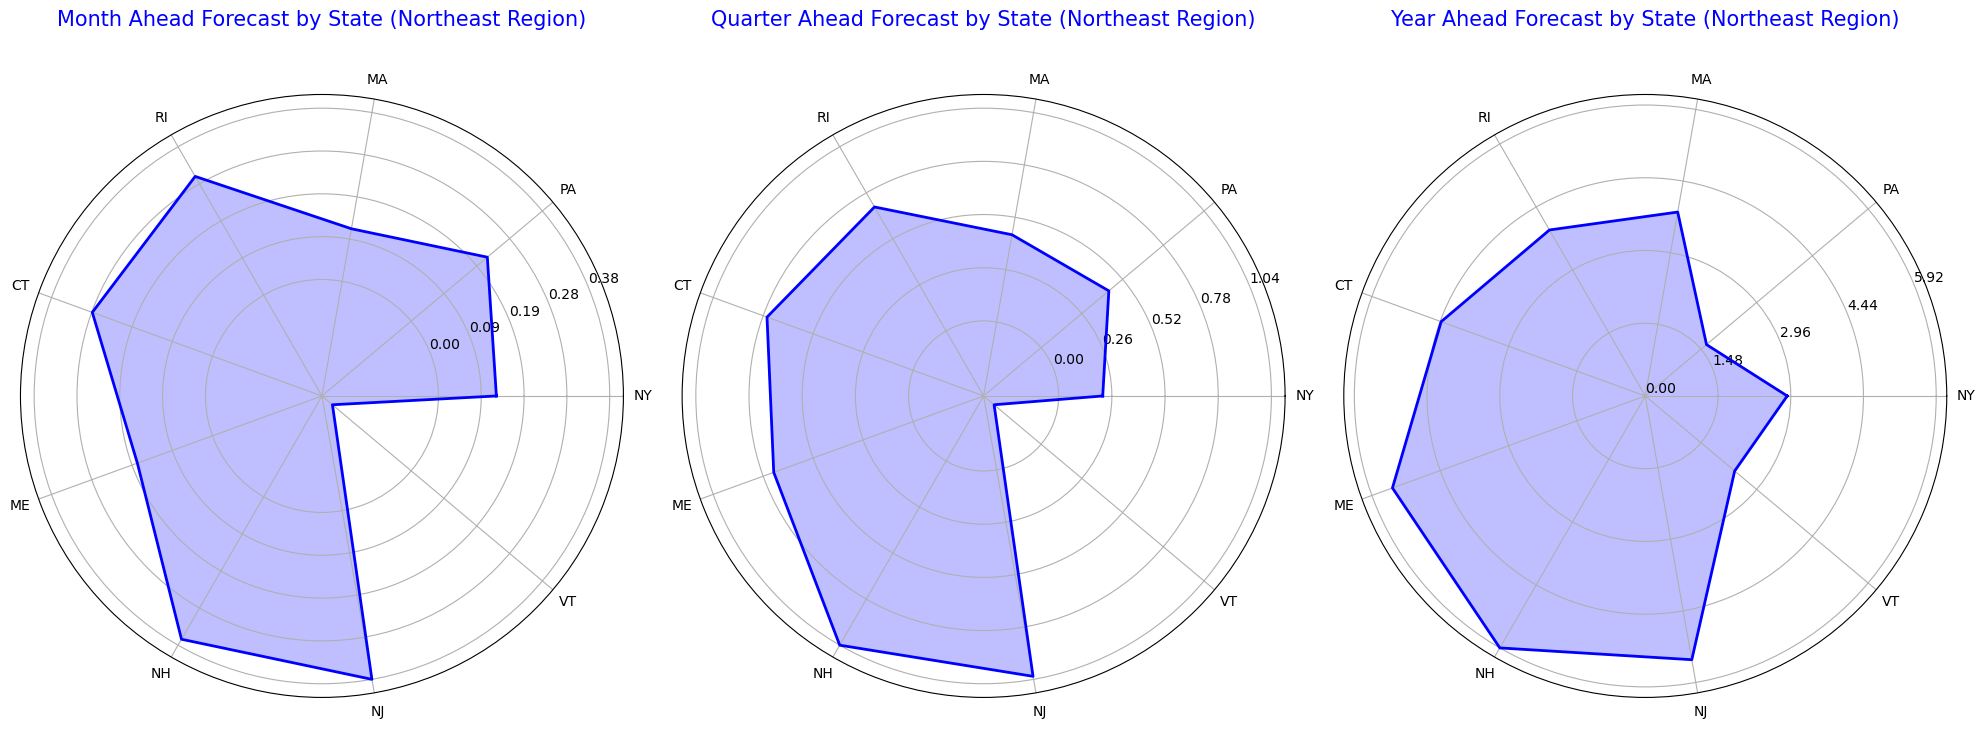

In [253]:
# Prepare data for radar plots
states = northeast_df['state_name'].unique()
num_vars = len(states)
# 2 * np.pi is a full circle (2 Radians)
# np.linspace creates a list of evenly spaced numbers over a specified interval
# endpoint=False means the stop value is not included in the list
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
# Add the first angle to the end to close the circle
angles += angles[:1] 

# Create Radar Plot
def create_radar_plot(ax, values, title):
    values += values[:1]
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    # Set y-ticks based on the maximum value in the data
    max_value = max(values)
    y_ticks = np.linspace(0, max_value, num=5)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks])
 
    # Exclude the last angle because it's a duplicate of the first angle
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(states)
    ax.set_title(title, size=15, color='blue', y=1.1)

# Create radar plots
# polar=True makes the plot circular
fig, axs = plt.subplots(1, 3, figsize=(20, 8), subplot_kw=dict(polar=True))

# Month Ahead Forecast
# This syntax is called a "List Comprehension" ([expression for item in iterable if condition])
month_values = [northeast_df[northeast_df['state_name'] == state]['month_ahead_forecast'].mean() for state in states]
create_radar_plot(axs[0], month_values, 'Month Ahead Forecast by State (Northeast Region)')

# Quarter Ahead Forecast
quarter_values = [northeast_df[northeast_df['state_name'] == state]['quarter_ahead_forecast'].mean() for state in states]
create_radar_plot(axs[1], quarter_values, 'Quarter Ahead Forecast by State (Northeast Region)')

# Year Ahead Forecast
year_values = [northeast_df[northeast_df['state_name'] == state]['year_ahead_forecast'].mean() for state in states]
create_radar_plot(axs[2], year_values, 'Year Ahead Forecast by State (Northeast Region)')

plt.tight_layout()
plt.show()

Q2) Are the sale prices and inventory listing going up or down overall in the US? - Brian

## Housing Prices

In [254]:
times_list = [
     '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
    '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
    '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
    '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
    '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
    '2024-09-30', '2024-10-31'
]

#load price data from zillow
price_df = pd.read_csv('data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
#Create Pricing dataframe
US_price_df = price_df

In [255]:
#Create region dataframes based on region lists
ne_price_df = price_df[price_df["StateName"].isin(northeast)]
south_price_df = price_df[price_df["StateName"].isin(south)]
midwest_price_df = price_df[price_df["StateName"].isin(midwest)]
west_price_df = price_df[price_df["StateName"].isin(west)]

ne_price_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,394913,1,"New York, NY",msa,NY,216209.133034,217127.899860,218055.176122,219934.196642,221879.987460,...,636222.199812,640261.759998,645659.925232,651762.255593,656416.260742,659493.785408,662237.503625,665976.304121,669998.634470,673519.052950
7,394974,7,"Philadelphia, PA",msa,PA,120885.284445,121153.967178,121337.332448,121789.805109,122227.665999,...,349573.821124,351115.528213,353427.278973,356146.742879,358185.675031,359102.300166,359482.428176,360201.829714,361364.601769,362689.244874
10,394404,10,"Boston, MA",msa,MA,213384.568454,214244.746892,215185.855599,216922.736735,218788.262189,...,661723.243713,664372.499113,668945.226638,674875.680306,679914.600480,682604.079147,684180.695185,685840.933507,687878.713525,689653.370211
27,394982,27,"Pittsburgh, PA",msa,PA,84395.278983,84495.704018,84617.192715,84854.852406,85194.462096,...,208920.171245,209358.194633,210318.378483,211713.704761,213350.822286,214712.383606,215057.269425,214592.658510,213809.354545,213565.398741
38,395005,39,"Providence, RI",msa,RI,139108.758342,139617.091379,140208.127549,141366.761903,142259.615021,...,457973.444131,459500.828871,462218.490216,466214.412599,470361.339202,473468.422875,476195.674417,479068.253700,481953.890214,484565.777904


### Prices - Northeast

In [256]:
#Create a dict. and a series
ne_price_summary_dict = {}

for time in times_list: 
    ne_price_summary_dict[time] = ne_price_df[time].median()
    
ne_price_series = pd.Series(ne_price_summary_dict)
ne_price_series.index = pd.to_datetime(ne_price_series.index)

### Prices - South

In [257]:
#Create a dict. and a series
south_price_summary_dict = {}

for time in times_list: 
    south_price_summary_dict[time] = south_price_df[time].median()
    
south_price_series = pd.Series(south_price_summary_dict)
south_price_series.index = pd.to_datetime(south_price_series.index)

### Prices - Midwest

In [258]:
#Create a dict. and a series
midwest_price_summary_dict = {}

for time in times_list: 
    midwest_price_summary_dict[time] = midwest_price_df[time].median()
    
midwest_price_series = pd.Series(midwest_price_summary_dict)
midwest_price_series.index = pd.to_datetime(midwest_price_series.index)

### Prices - West

In [259]:
#Create a dict. and a series
west_price_summary_dict = {}

for time in times_list: 
    west_price_summary_dict[time] = west_price_df[time].median()
    
west_price_series = pd.Series(west_price_summary_dict)
west_price_series.index = pd.to_datetime(west_price_series.index)

Text(0, 0.5, 'Med. House Price')

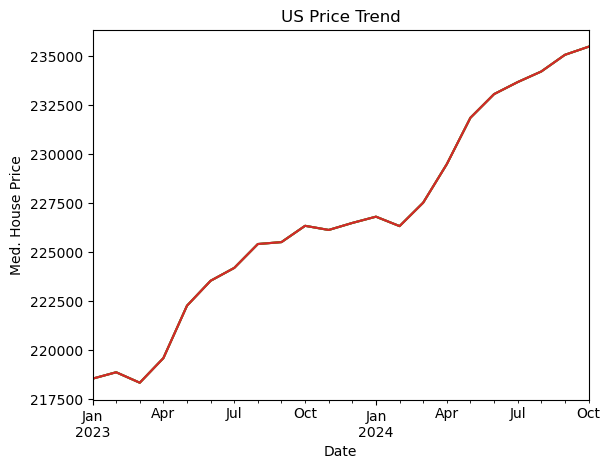

In [260]:
#Create a dict., series, and line chart
US_price_summary_dict = {}

for time in times_list: 
    US_price_summary_dict[time] = US_price_df[time].median()
    
US_price_series = pd.Series(US_price_summary_dict)
US_price_series.index = pd.to_datetime(US_price_series.index)
US_price_series.plot.line()
US_price_series.plot.line().set_title('US Price Trend')
US_price_series.plot.line().set_xlabel('Date')
US_price_series.plot.line().set_ylabel('Med. House Price')

In [261]:
print(US_price_series['2023-01-31'])
print(US_price_series['2024-10-31'])

218521.5709765556
235483.50964767436


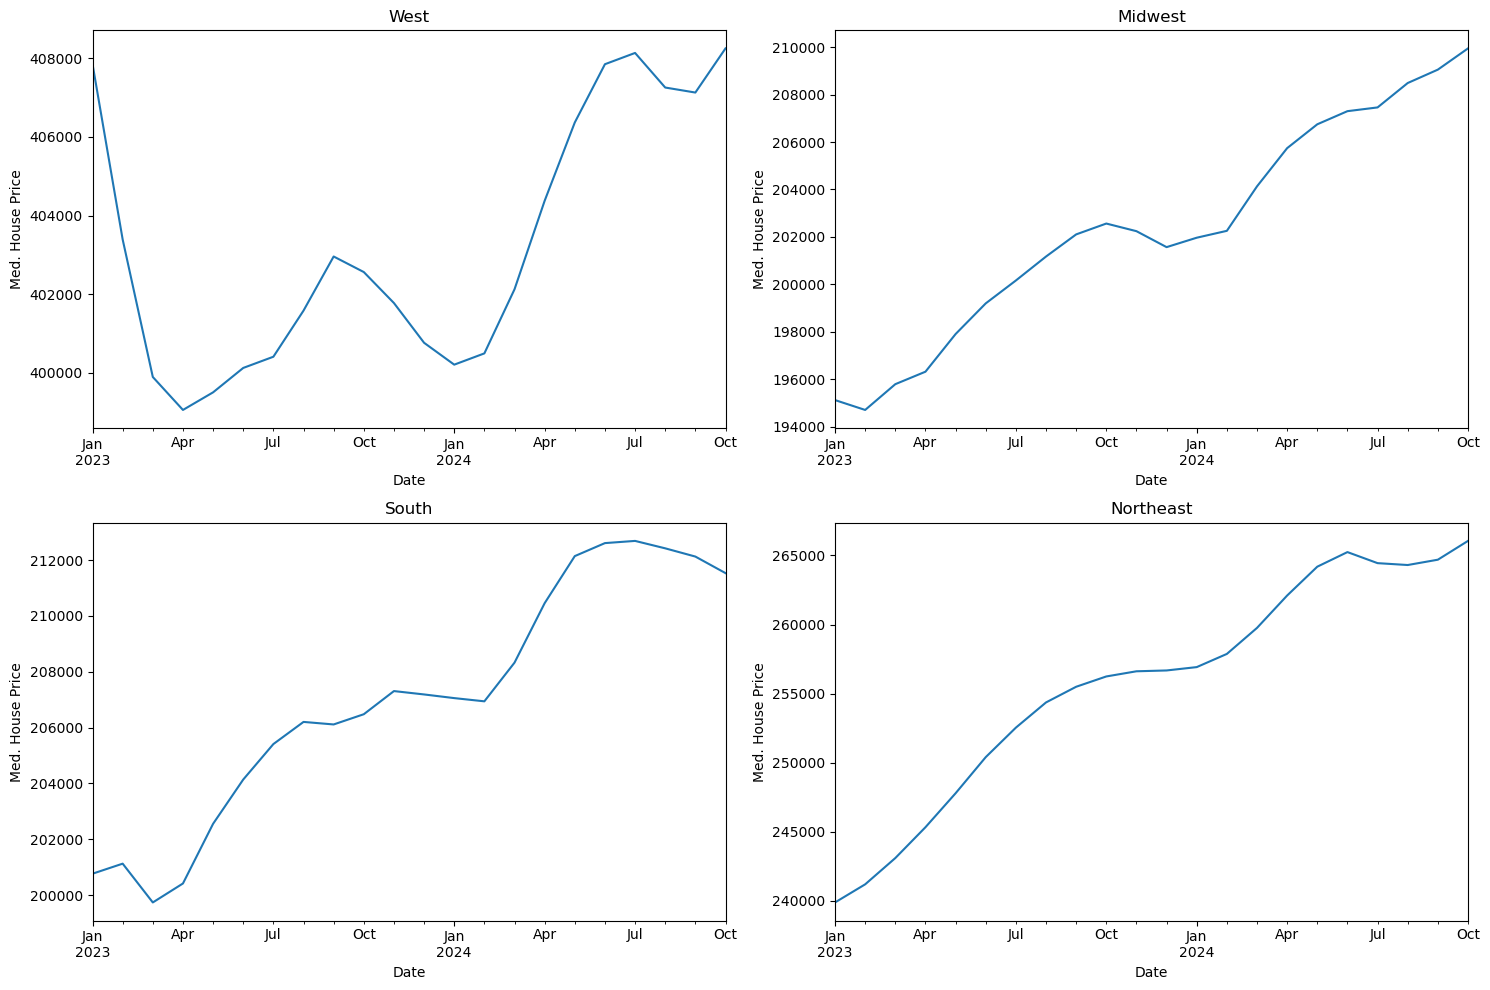

In [262]:
#Create 4 line charts for each region
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

west_price_series.plot.line(ax=axes[0,0])
axes[0, 0].set_title('West')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Med. House Price')

midwest_price_series.plot.line(ax=axes[0,1])
axes[0, 1].set_title('Midwest')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Med. House Price')

south_price_series.plot.line(ax=axes[1,0])
axes[1,0].set_title('South')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Med. House Price')

ne_price_series.plot.line(ax=axes[1,1])
axes[1, 1].set_title('Northeast')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Med. House Price')

plt.tight_layout()
plt.show()

## Housing Inventory

In [263]:
#Load inventory data from zillow
inventory_df = pd.read_csv("data/Metro_invt_fs_uc_sfrcondo_sm_month.csv")
#create US inventory DF
inventory_df
US_inventory_df = inventory_df

#Create region dataframes based on region lists
ne_inventory_df = inventory_df[inventory_df["StateName"].isin(northeast)]
south_inventory_df = inventory_df[inventory_df["StateName"].isin(south)]
midwest_inventory_df = inventory_df[inventory_df["StateName"].isin(midwest)]
west_inventory_df = inventory_df[inventory_df["StateName"].isin(west)]

### Inventory - Northeast

In [264]:
#Create a dict. and a series
ne_inventory_summary_dict = {}

for time in times_list: 
    ne_inventory_summary_dict[time] = ne_inventory_df[time].median()
    
ne_inventory_series = pd.Series(ne_inventory_summary_dict)
ne_inventory_series.index = pd.to_datetime(ne_inventory_series.index)

### Inventory - South

In [265]:
#Create a dict. and a series
south_inventory_summary_dict = {}

for time in times_list: 
    south_inventory_summary_dict[time] = south_inventory_df[time].median()
    
south_inventory_series = pd.Series(south_inventory_summary_dict)
south_inventory_series.index = pd.to_datetime(south_inventory_series.index)

### Inventory - Midwest

In [266]:
#Create a dict. and a series
midwest_inventory_summary_dict = {}

for time in times_list: 
    midwest_inventory_summary_dict[time] = midwest_inventory_df[time].median()
    
midwest_inventory_series = pd.Series(midwest_inventory_summary_dict)
midwest_inventory_series.index = pd.to_datetime(midwest_inventory_series.index)

### Inventory - West

Text(0, 0.5, 'Med. House inventory')

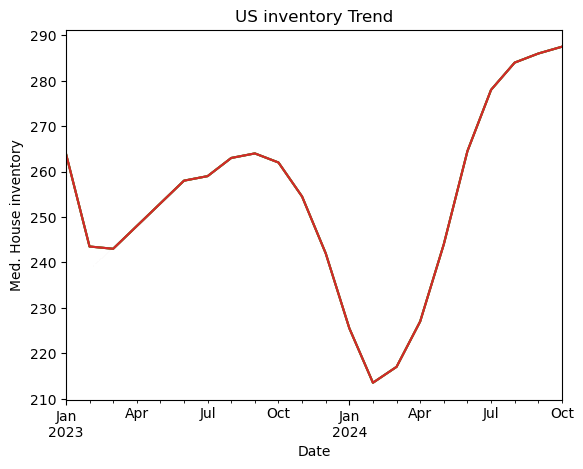

In [267]:
#Create a dict. and a series
west_inventory_summary_dict = {}

for time in times_list: 
    west_inventory_summary_dict[time] = west_inventory_df[time].median()
    
west_inventory_series = pd.Series(west_inventory_summary_dict)
west_inventory_series.index = pd.to_datetime(west_inventory_series.index)

#Create a dict., series, and line chart
US_inventory_summary_dict = {}

for time in times_list: 
    US_inventory_summary_dict[time] = US_inventory_df[time].median()
    
US_inventory_series = pd.Series(US_inventory_summary_dict)
US_inventory_series.index = pd.to_datetime(US_inventory_series.index)
US_inventory_series.plot.line()
US_inventory_series.plot.line().set_title('US inventory Trend')
US_inventory_series.plot.line().set_xlabel('Date')
US_inventory_series.plot.line().set_ylabel('Med. House inventory')

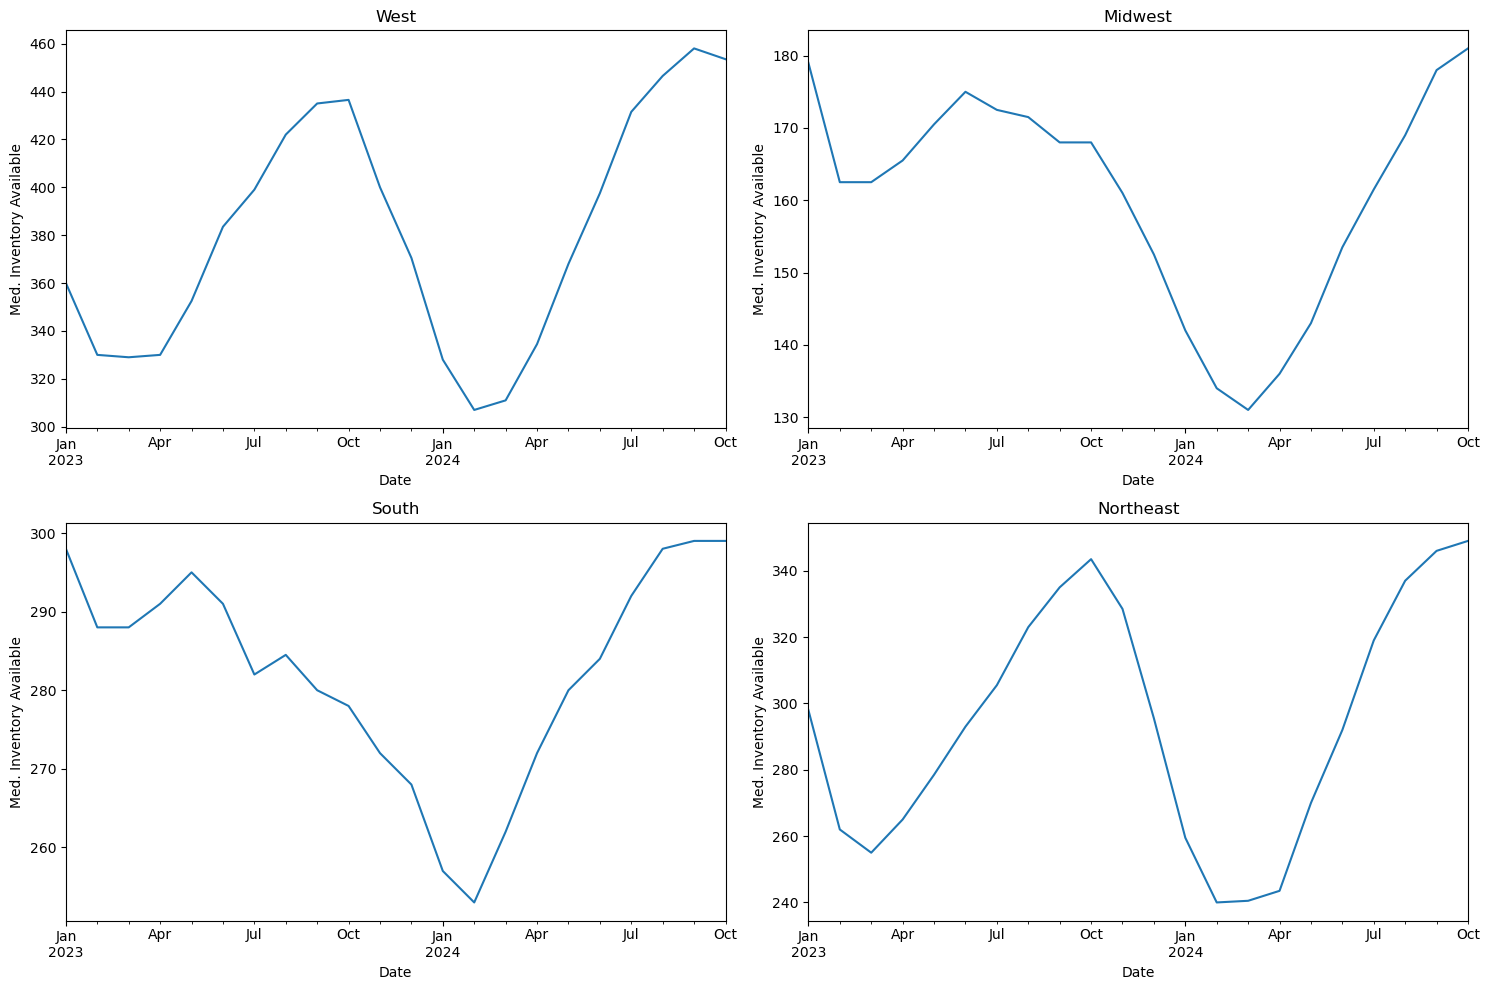

In [268]:
#Create 4 line charts for each region
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

west_inventory_series.plot.line(ax=axes[0,0])
axes[0, 0].set_title('West')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Med. Inventory Available')

midwest_inventory_series.plot.line(ax=axes[0,1])
axes[0, 1].set_title('Midwest')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Med. Inventory Available')

south_inventory_series.plot.line(ax=axes[1,0])
axes[1,0].set_title('South')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Med. Inventory Available')

ne_inventory_series.plot.line(ax=axes[1,1])
axes[1, 1].set_title('Northeast')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Med. Inventory Available')

plt.tight_layout()
plt.show()

### Q2) Conclusion - 
Sales prices come from ZHVI value for all data available from January of 20023 to October of 2024. In this time frame we see a stable increase in the median home value in all 4 regions and the overall US market. Median home values at the start of 2023 were $219k and by the end of Oct. 2024 they have reaced a value of $235k.

The inventory dataset provides the count of unique listings that were active at any time in a given month, across all housing types for the US. We can see a normal cyclical seasonal pattern, with higher median of inventory in the summer and lower inventory in the winter. We can also see the median amount of inventory in summer of 2024 was higher than at the same time in 2023. With intrest rates coming down year over year there has been more willingness to put an old house on the market to get a new one. 

With the trends we are seeing home median home values are contining to rise and while we will see inventory fall in the winter we excpect to see the inventory rise YoY.

Q3) Should I wait to invest or should I invest now and if so then where should I invest. (You could recommend more than one place)? - Sipho

Q4) How long some of the real-estate stays on the market before they rent or sell? - Tony

In [269]:
# Load Zillow data - "Days on Market and Price Cuts" and inspect data

## Data Sources ##
# Mean Days to Pending (Smooth, All Homes, Monthly)
# Mean Days to Close (Smooth, All Homes, Monthly)

df_duration_pending = pd.read_csv('data/Metro_mean_doz_pending_uc_sfrcondo_sm_month.csv')
df_duration_close = pd.read_csv('data/Metro_mean_days_to_close_uc_sfrcondo_sm_month.csv')

df_duration_pending.columns.name = "Pending Data"
df_duration_close.columns.name = "Closing Data"

# Common function we could use to cut down on the amount of code in our notebook
def dataframe_check(dataframe_name):
    display(dataframe_name.head(5))
    display(dataframe_name.tail(5))
    display(dataframe_name.count())

dataframe_check(df_duration_pending)
dataframe_check(df_duration_close)

Pending Data,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,51.0,48.0,45.0,43.0,44.0,...,49.0,52.0,49.0,43.0,39.0,37.0,38.0,41.0,44.0,46.0
1,394913,1,"New York, NY",msa,NY,68.0,65.0,63.0,64.0,66.0,...,68.0,71.0,67.0,58.0,51.0,49.0,49.0,52.0,55.0,58.0
2,753899,2,"Los Angeles, CA",msa,CA,35.0,32.0,31.0,32.0,33.0,...,40.0,41.0,37.0,33.0,30.0,29.0,30.0,33.0,36.0,38.0
3,394463,3,"Chicago, IL",msa,IL,51.0,44.0,40.0,39.0,40.0,...,42.0,43.0,38.0,31.0,26.0,24.0,24.0,25.0,28.0,31.0
4,394514,4,"Dallas, TX",msa,TX,46.0,42.0,38.0,37.0,38.0,...,51.0,52.0,49.0,43.0,39.0,38.0,40.0,45.0,50.0,54.0


Pending Data,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
721,395241,881,"Yankton, SD",msa,SD,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0
722,394403,899,"Borger, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0
723,753925,910,"Vineyard Haven, MA",msa,MA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.0
724,786263,913,"Ruidoso, NM",msa,NM,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,86.0,89.0
725,394805,916,"Los Alamos, NM",msa,NM,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18.0,17.0,19.0,19.0,15.0,13.0,21.0


Pending Data
RegionID      726
SizeRank      726
RegionName    726
RegionType    726
StateName     725
             ... 
2024-06-30    678
2024-07-31    681
2024-08-31    688
2024-09-30    693
2024-10-31    726
Length: 85, dtype: int64

Closing Data,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,35.0,34.0,34.0,35.0,36.0,...,33.0,34.0,34.0,33.0,32.0,33.0,34.0,34.0,34.0,34.0
1,394913,1,"New York, NY",msa,NY,57.0,53.0,50.0,51.0,53.0,...,53.0,54.0,55.0,54.0,52.0,51.0,53.0,54.0,55.0,55.0
2,753899,2,"Los Angeles, CA",msa,CA,34.0,32.0,33.0,33.0,34.0,...,30.0,31.0,30.0,30.0,29.0,29.0,29.0,29.0,29.0,30.0
3,394463,3,"Chicago, IL",msa,IL,43.0,42.0,42.0,44.0,45.0,...,37.0,38.0,37.0,37.0,36.0,37.0,38.0,38.0,38.0,37.0
4,394514,4,"Dallas, TX",msa,TX,21.0,21.0,21.0,22.0,22.0,...,28.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,28.0


Closing Data,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
618,394869,869,"Moberly, MO",msa,MO,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,32.0,34.0,34.0,35.0,34.0,38.0
619,395004,872,"Prineville, OR",msa,OR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,34.0,37.0,39.0,40.0,38.0,38.0,36.0
620,394418,880,"Brookings, OR",msa,OR,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.0,33.0,35.0,33.0
621,394805,916,"Los Alamos, NM",msa,NM,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,32.0,33.0,33.0,32.0,33.0
622,395112,922,"Spirit Lake, IA",msa,IA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,31.0,32.0,35.0,32.0,31.0,31.0


Closing Data
RegionID      623
SizeRank      623
RegionName    623
RegionType    623
StateName     622
             ... 
2024-05-31    600
2024-06-30    606
2024-07-31    610
2024-08-31    619
2024-09-30    623
Length: 84, dtype: int64

## Days to Pending

How long it takes homes in a region to change to pending status on Zillow.com after first being shown as for sale. The reported figure indicates the number of days (mean or median) that it took for homes that went pending during the week being reported, to go pending. This differs from the old “Days on Zillow” metric in that it excludes the in-contract period before a home sells.

In [270]:
#Rename column headers to our standards used above
df_duration_pending = df_duration_pending.rename(columns={"RegionID": "region_id", 
                        "SizeRank": "size_rank", 
                        "RegionName": "metro_area",
                        "RegionType": "region_type",
                        "StateName": "state_name"})

df_duration_close = df_duration_close.rename(columns={"RegionID": "region_id", 
                        "SizeRank": "size_rank", 
                        "RegionName": "metro_area",
                        "RegionType": "region_type",
                        "StateName": "state_name"})

# drop unnecessary columns
df_duration_pending = df_duration_pending.drop(["region_id","size_rank","region_type"], axis=1)
df_duration_close = df_duration_close.drop(["region_id","size_rank","region_type"], axis=1)

# drop any column over 2 years old
df_duration_pending = df_duration_pending.drop(df_duration_pending.columns[2:-24], axis=1)
df_duration_close = df_duration_close.drop(df_duration_close.columns[2:-24], axis=1)

# Add the region column
df_duration_pending.insert(2, "region", df["state_name"].map(region_map))
display(df_duration_pending.head(5))

df_duration_close.insert(2, "region", df["state_name"].map(region_map))
display(df_duration_close.head(5))

Pending Data,metro_area,state_name,region,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,United States,NaN,NaN,37.0,42.0,49.0,51.0,49.0,43.0,37.0,...,49.0,52.0,49.0,43.0,39.0,37.0,38.0,41.0,44.0,46.0
1,"New York, NY",NY,northeast,60.0,65.0,72.0,76.0,73.0,65.0,58.0,...,68.0,71.0,67.0,58.0,51.0,49.0,49.0,52.0,55.0,58.0
2,"Los Angeles, CA",CA,west,39.0,44.0,50.0,52.0,49.0,42.0,35.0,...,40.0,41.0,37.0,33.0,30.0,29.0,30.0,33.0,36.0,38.0
3,"Chicago, IL",IL,midwest,37.0,43.0,50.0,52.0,46.0,37.0,30.0,...,42.0,43.0,38.0,31.0,26.0,24.0,24.0,25.0,28.0,31.0
4,"Dallas, TX",TX,south,33.0,40.0,46.0,49.0,45.0,37.0,30.0,...,51.0,52.0,49.0,43.0,39.0,38.0,40.0,45.0,50.0,54.0


Closing Data,metro_area,state_name,region,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,United States,NaN,NaN,35.0,35.0,34.0,35.0,34.0,34.0,33.0,...,33.0,34.0,34.0,33.0,32.0,33.0,34.0,34.0,34.0,34.0
1,"New York, NY",NY,northeast,53.0,52.0,53.0,55.0,55.0,55.0,53.0,...,53.0,54.0,55.0,54.0,52.0,51.0,53.0,54.0,55.0,55.0
2,"Los Angeles, CA",CA,west,30.0,30.0,30.0,31.0,31.0,30.0,29.0,...,30.0,31.0,30.0,30.0,29.0,29.0,29.0,29.0,29.0,30.0
3,"Chicago, IL",IL,midwest,38.0,38.0,37.0,38.0,37.0,37.0,37.0,...,37.0,38.0,37.0,37.0,36.0,37.0,38.0,38.0,38.0,37.0
4,"Dallas, TX",TX,south,28.0,29.0,28.0,29.0,29.0,29.0,28.0,...,28.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,28.0


In [271]:
# Common function we could use to cut down on the amount of code in our notebook
## This function drops duplicates missing/null values and provides statistics prior to and after changes
def check_dup_null(dataframe_name):
    
    # List number of rows
    print("Before Dropping - number of rows,columns: ", dataframe_name.shape)
    
    # Drop the duplicates - (no duplicates found)
    dataframe_name = dataframe_name.drop_duplicates()
    
    # Drop Missing/Null Values (no null values found)
    print("Sum of null values:\n", dataframe_name.isnull().sum())
    dataframe_name = dataframe_name.dropna()
    
    print("After Dropping - number of rows,columns: ", dataframe_name.shape)
    
    display(dataframe_name.count())
    
    display(dataframe_name.head(5))
    display(dataframe_name.tail(5))
    
    return dataframe_name


In [272]:
# Display drop results for Mean Days to Pending Data
df_duration_pending = check_dup_null(df_duration_pending)

Before Dropping - number of rows,columns:  (726, 27)
Sum of null values:
 Pending Data
metro_area      0
state_name      1
region          1
2022-11-30    190
2022-12-31    186
2023-01-31    170
2023-02-28    165
2023-03-31    160
2023-04-30    159
2023-05-31    158
2023-06-30    158
2023-07-31    157
2023-08-31    156
2023-09-30    155
2023-10-31    155
2023-11-30    154
2023-12-31    146
2024-01-31    106
2024-02-29     83
2024-03-31     64
2024-04-30     57
2024-05-31     51
2024-06-30     48
2024-07-31     45
2024-08-31     38
2024-09-30     33
2024-10-31      0
dtype: int64
After Dropping - number of rows,columns:  (535, 27)


Pending Data
metro_area    535
state_name    535
region        535
2022-11-30    535
2022-12-31    535
2023-01-31    535
2023-02-28    535
2023-03-31    535
2023-04-30    535
2023-05-31    535
2023-06-30    535
2023-07-31    535
2023-08-31    535
2023-09-30    535
2023-10-31    535
2023-11-30    535
2023-12-31    535
2024-01-31    535
2024-02-29    535
2024-03-31    535
2024-04-30    535
2024-05-31    535
2024-06-30    535
2024-07-31    535
2024-08-31    535
2024-09-30    535
2024-10-31    535
dtype: int64

Pending Data,metro_area,state_name,region,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,"New York, NY",NY,northeast,60.0,65.0,72.0,76.0,73.0,65.0,58.0,...,68.0,71.0,67.0,58.0,51.0,49.0,49.0,52.0,55.0,58.0
2,"Los Angeles, CA",CA,west,39.0,44.0,50.0,52.0,49.0,42.0,35.0,...,40.0,41.0,37.0,33.0,30.0,29.0,30.0,33.0,36.0,38.0
3,"Chicago, IL",IL,midwest,37.0,43.0,50.0,52.0,46.0,37.0,30.0,...,42.0,43.0,38.0,31.0,26.0,24.0,24.0,25.0,28.0,31.0
4,"Dallas, TX",TX,south,33.0,40.0,46.0,49.0,45.0,37.0,30.0,...,51.0,52.0,49.0,43.0,39.0,38.0,40.0,45.0,50.0,54.0
5,"Houston, TX",TX,south,41.0,47.0,54.0,57.0,55.0,49.0,43.0,...,58.0,63.0,60.0,54.0,49.0,47.0,49.0,53.0,57.0,60.0


Pending Data,metro_area,state_name,region,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
669,"Lebanon, MO",MO,south,43.0,51.0,58.0,52.0,49.0,44.0,50.0,...,57.0,62.0,68.0,64.0,63.0,55.0,55.0,49.0,47.0,41.0
670,"Vernal, UT",UT,south,60.0,54.0,57.0,60.0,65.0,55.0,49.0,...,71.0,69.0,69.0,71.0,69.0,64.0,60.0,58.0,72.0,63.0
691,"Berlin, NH",NH,northeast,48.0,44.0,42.0,50.0,67.0,67.0,52.0,...,60.0,67.0,72.0,69.0,62.0,53.0,47.0,57.0,59.0,67.0
693,"Breckenridge, CO",CO,midwest,54.0,65.0,70.0,77.0,62.0,53.0,37.0,...,78.0,78.0,73.0,56.0,40.0,34.0,40.0,52.0,65.0,82.0
703,"Mineral Wells, TX",TX,midwest,52.0,64.0,82.0,85.0,85.0,81.0,77.0,...,97.0,115.0,113.0,118.0,110.0,107.0,106.0,102.0,99.0,105.0


In [273]:
# Display drop results for Mean Days to Closing Data
df_duration_close = check_dup_null(df_duration_close)

Before Dropping - number of rows,columns:  (623, 27)
Sum of null values:
 Closing Data
metro_area      0
state_name      1
region          1
2022-10-31    149
2022-11-30    148
2022-12-31    147
2023-01-31    145
2023-02-28    137
2023-03-31    133
2023-04-30    131
2023-05-31    128
2023-06-30    127
2023-07-31    127
2023-08-31    128
2023-09-30    124
2023-10-31    124
2023-11-30    122
2023-12-31    118
2024-01-31    114
2024-02-29     89
2024-03-31     47
2024-04-30     32
2024-05-31     23
2024-06-30     17
2024-07-31     13
2024-08-31      4
2024-09-30      0
dtype: int64
After Dropping - number of rows,columns:  (467, 27)


Closing Data
metro_area    467
state_name    467
region        467
2022-10-31    467
2022-11-30    467
2022-12-31    467
2023-01-31    467
2023-02-28    467
2023-03-31    467
2023-04-30    467
2023-05-31    467
2023-06-30    467
2023-07-31    467
2023-08-31    467
2023-09-30    467
2023-10-31    467
2023-11-30    467
2023-12-31    467
2024-01-31    467
2024-02-29    467
2024-03-31    467
2024-04-30    467
2024-05-31    467
2024-06-30    467
2024-07-31    467
2024-08-31    467
2024-09-30    467
dtype: int64

Closing Data,metro_area,state_name,region,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
1,"New York, NY",NY,northeast,53.0,52.0,53.0,55.0,55.0,55.0,53.0,...,53.0,54.0,55.0,54.0,52.0,51.0,53.0,54.0,55.0,55.0
2,"Los Angeles, CA",CA,west,30.0,30.0,30.0,31.0,31.0,30.0,29.0,...,30.0,31.0,30.0,30.0,29.0,29.0,29.0,29.0,29.0,30.0
3,"Chicago, IL",IL,midwest,38.0,38.0,37.0,38.0,37.0,37.0,37.0,...,37.0,38.0,37.0,37.0,36.0,37.0,38.0,38.0,38.0,37.0
4,"Dallas, TX",TX,south,28.0,29.0,28.0,29.0,29.0,29.0,28.0,...,28.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,28.0
6,"Washington, DC",VA,south,31.0,31.0,31.0,31.0,31.0,31.0,30.0,...,29.0,31.0,30.0,30.0,28.0,28.0,29.0,29.0,29.0,29.0


Closing Data,metro_area,state_name,region,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
581,"Crawfordsville, IN",IN,south,36.0,35.0,34.0,34.0,34.0,33.0,33.0,...,33.0,34.0,33.0,34.0,32.0,35.0,36.0,37.0,35.0,34.0
584,"Easton, MD",MD,south,39.0,40.0,41.0,42.0,39.0,38.0,36.0,...,43.0,45.0,45.0,43.0,40.0,39.0,41.0,40.0,39.0,39.0
589,"Kill Devil Hills, NC",NC,northeast,41.0,42.0,43.0,44.0,41.0,40.0,38.0,...,41.0,43.0,39.0,38.0,37.0,38.0,38.0,37.0,38.0,37.0
594,"Lebanon, MO",MO,west,35.0,34.0,34.0,33.0,31.0,33.0,33.0,...,34.0,35.0,36.0,38.0,36.0,34.0,32.0,33.0,34.0,36.0
609,"Breckenridge, CO",CO,midwest,35.0,34.0,32.0,34.0,35.0,36.0,36.0,...,34.0,35.0,36.0,35.0,34.0,34.0,33.0,33.0,32.0,34.0


In [274]:
# PENDING - Group by region and calculate mean forecasts
grouped_df_duration_pending = (df_duration_pending.groupby('region').mean(numeric_only=True)).reset_index()
display(grouped_df_duration_pending)

# CLOSING - Group by region and calculate mean forecasts
grouped_df_duration_closing = (df_duration_close.groupby('region').mean(numeric_only=True)).reset_index()
display(grouped_df_duration_closing)

Pending Data,region,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,midwest,39.028571,44.535714,50.778571,53.764286,51.635714,46.007143,40.700000,37.850000,37.207143,...,53.821429,55.957143,53.871429,48.578571,43.835714,41.592857,42.000000,44.735714,47.957143,51.014286
1,northeast,36.384615,41.292308,47.707692,50.476923,48.938462,42.953846,38.215385,34.892308,34.138462,...,51.307692,53.953846,50.800000,45.507692,40.846154,38.907692,38.261538,40.430769,42.661538,46.569231
2,south,37.306977,42.632558,48.669767,51.641860,49.758140,44.023256,39.065116,35.744186,35.446512,...,53.316279,56.079070,53.804651,48.227907,43.837209,41.269767,41.590698,43.544186,46.990698,50.427907
3,west,38.643478,43.669565,50.078261,52.747826,51.121739,44.965217,39.147826,35.504348,34.869565,...,51.904348,54.173913,51.434783,45.930435,41.643478,39.686957,40.156522,42.713043,45.104348,47.739130


Closing Data,region,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,midwest,35.393162,35.085470,34.743590,35.085470,34.820513,34.555556,34.051282,34.410256,35.076923,...,33.957265,34.606838,34.598291,34.384615,33.811966,34.051282,34.606838,34.726496,34.487179,34.213675
1,northeast,38.651515,38.424242,38.272727,38.439394,37.909091,37.530303,36.924242,37.257576,38.000000,...,36.924242,37.560606,37.363636,37.106061,36.424242,36.833333,37.575758,37.939394,37.863636,37.333333
2,south,34.962366,34.870968,34.650538,34.827957,34.430108,34.193548,33.715054,34.172043,34.994624,...,33.607527,34.225806,34.069892,33.758065,33.193548,33.618280,34.430108,34.618280,34.370968,34.134409
3,west,34.704082,34.602041,34.306122,34.520408,34.255102,34.010204,33.469388,33.857143,34.459184,...,33.244898,33.979592,33.928571,33.785714,32.989796,33.275510,33.959184,34.204082,34.071429,34.051020


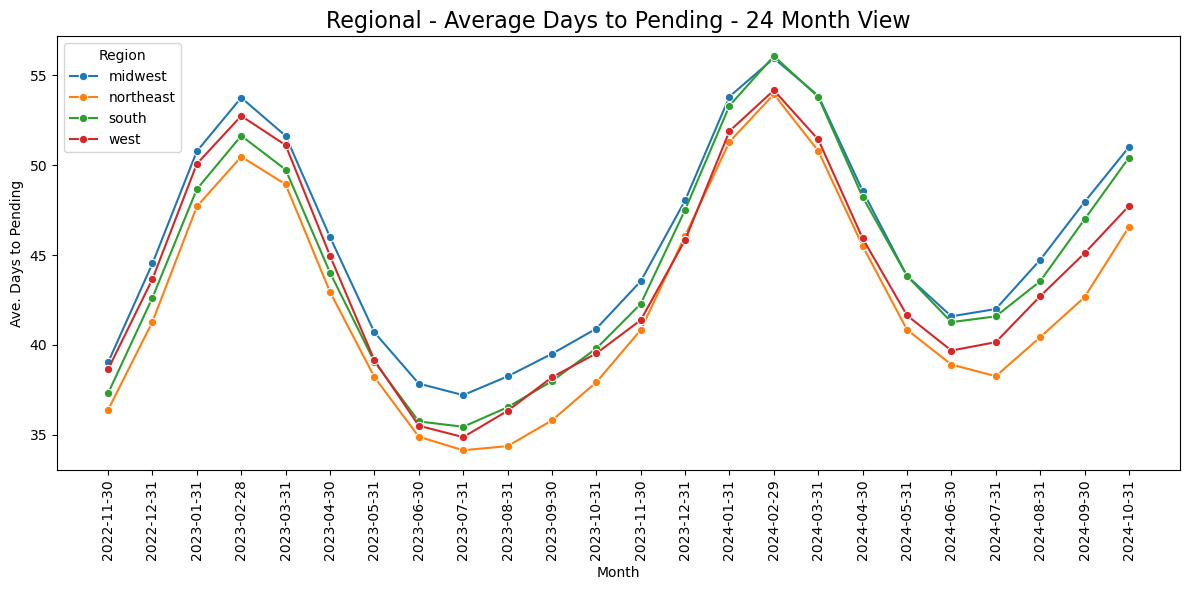

In [275]:
# PENDING - Melt the DataFrame for easier plotting
df_melted_pending = pd.melt(grouped_df_duration_pending, id_vars=["region"], var_name="Month", value_name="Ave. Days to Pending")

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted_pending, x="Month", y="Ave. Days to Pending", hue="region", marker="o")

# Customize the plot
plt.title("Regional - Average Days to Pending - 24 Month View", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Ave. Days to Pending")
plt.xticks(rotation=90)
plt.legend(title="Region")
plt.tight_layout()

# Show plot
plt.show()


### I WAS THINKING OF ADDING A BOXPLOT HERE TO HIGHLIGHT THE (IN?)SIGNIFICANCE IN AVERAGE DAYS TO PENDING

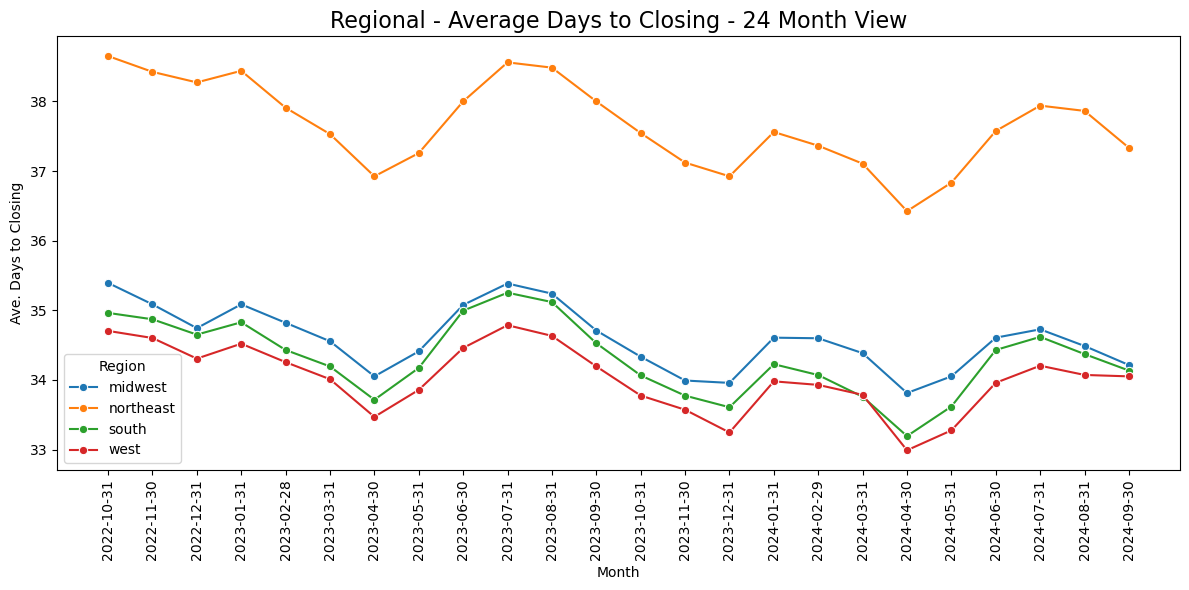

In [276]:
# MEAN CLOSING DATE DATA - Melt the DataFrame for easier plotting
df_melted_closing = pd.melt(grouped_df_duration_closing, id_vars=["region"], var_name="Month", value_name="Ave. Days to Closing")

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted_closing, x="Month", y="Ave. Days to Closing", hue="region", marker="o")

# Customize the plot
plt.title("Regional - Average Days to Closing - 24 Month View", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Ave. Days to Closing")
plt.xticks(rotation=90)
plt.legend(title="Region")
plt.tight_layout()

# Show plot
plt.show()


### I WAS THINKING OF ADDING BOXPLOTS HERE TO HIGHLIGHT THE SIGNIFICANCE IN AVERAGE DAYS TO CLOSING

## Q4) Market Durations by Region - Line Plot Conclusions
* Northeast properties move to 'sale pending' status more quickly than other regions
* However, Northeast properties are much slower when moving to the 'sale close' status compared to the other regions
* Midwest, South, and West properties are all fairly similar in average days to close

Q5) How much average profit I could expect from my investments in terms of sale (% dollars) after paying mortgage. Calculate my ~ROI

Q6) How much average monthly income I could expect from my investments in terms of lease/rent after upgrading properties, paying mortgage, and paying taxes. Calculate my ~ROI.